# Exploring the Butcher Factor #

## Robert M. Corless ##
### Auckland, 2024-03-26 ###

### Part II of my talk for woRK 2024 ###

This file, named ButcherFactor.ipynb distributed through my github site, is a Jupyter notebook using a Maple kernel. It contains some programs associated with it useful for Hermite interpolation and for Birkhoff interpolation.



In [1]:
#
# BHIP: Barycentric Hermite Interpolation Program
#
# (c) Robert M. Corless, December 2007, August 2012, March 2024 (trimmed old cruft)
#
# Compute the barycentric form of the unique Hermite interpolant
# of the polynomial given by values and derivative values of
# p(t) at the nodes tau.
#
# CALLING SEQUENCES
#
#   ( p, gam ) := BHIP( flist, tau, t );
#   ( p, gam ) := BHIP( ftayl, tau, t, 'Taylor' = true, 'Denominator' = q );
#   ( p, gam, DD ) := BHIP( ftayl, tau, t, <opts>, 'Dmat'=true )
#
# Input:
#    flist :: list of lists of derivative values
#             [ [f[1,0],f[1,1],...,f[1,s[1]-1]],
#               [f[2,0],f[2,1],...,f[2,s[2]-1]],
#                ...
#               [f[n,0],f[n,1],...,f[n,s[n]-1]] ]
#    or, equivalently, when 'Taylor' is true,
#    ftayl :: list of lists of Taylor Coefficients,
#             same as above but divided by factorials
#             [ [f[1,0]/0!,f[1,1]/1!,...,f[1,s[1]-1]/(s[1]-1)!],
#               [f[2,0]/0!,f[2,1]/1!,...,f[2,s[2]-1]/(s[2]-1)!],
#                ...
#               [f[n,0]/0!,f[n,1]/1!,...,f[n,s[n]-1]/(s[n]-1)!] ]
#
#    As a convenience, singleton lists may be entered without []
#    If plist[i] = [] is empty, then nothing
#    is known about f at t = tau[i], and
#    tau[i] will not figure in the output.
#    Sometimes this is useful.  Not all flist[i] may
#    be empty.
#
#    tau :: list of distinct complex nodes
#           [tau[1],tau[2],...,tau[n]]
#
#    t :: name of the variable to use
#
#    Taylor :: boolean, 'true' if input is in Taylor form
#
#    Denominator :: polynomial in t, default 1 if absent
#                :: list of lists of values and derivatives
#                   or Taylor coefficients if Taylor is true
#
#    N.B.   f[i,j] = (D@@j)(f)(tau[i])  0 <= j <= s[i]-1
#          = flist[i][j+1]
#    Dmat :: boolean, 'true' if differentiation matrix desired
#
# Output:
#         p :: The unique (rational) Hermite interpolant, in barycentric
#              form.  Namely,
#              #w(t)*add(add(gam[i,j]/(t-tau[i])^(1+j)*add(p[i,j]/j!*(t-tau[i])^k)
#              This can be converted to distributed form by calling
#              distrib(p);
#
#         gam :: The Array(1..n, 0..smax-1) of coefficients
#
#         Here w(t) = mul( ( t-tau[i])^s[i], i = 1..n )
#              smax = max( op(s) )
#         and  s = list of sizes of each list in plist,
#              so s[i] is the number of pieces of
#              information at node tau[i].
#
#         DD --- Differentiation matrix on the nodes tau
#
# Processing: local Laurent series.
#             This approach is different to that of
# Reference: C. Schneider & W.Werner, "Hermite
#            Interpolation: The Barycentric Approach",
#            Computing 46, 1991, pp 35-51.
#
BHIP := proc( pin::list, tau::list, t::name,
              {Taylor::truefalse:=true}, 
              {Conditioning::truefalse:=false}, 
              {Dmat::truefalse:=false},
              {Denominator::{algebraic,list}:=1} )
        local brks, d, DD, denr, dens, dgam, 
              dr, g, gam, ghat,h, i, irow, j,
              k, mu, n, numr, nums,
              p, P, q, r, rs, rt, s, smax, sq;

        n := nops(tau);
        if nops(pin) <> n then
           error "Mismatched size of node list and data list"
        end if;

        if nops(convert(tau,set)) < n then
           error "Nodes must be distinct, with confluency explicitly specified."
        end if;

        p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok
        s := map(nops,p); # confluency
        smax := max(op(s));
        if smax = 0 then
          error "At least one piece of data is necessary."
        end if;
        d := -1 + add( s[i], i=1..nops(s) );  # degree bound
        p := `if`( Taylor, p, [seq([seq(p[i][j]/(j-1)!,j=1..s[i])],i=1..n)] );

        gam := Array( 1..n, 0..smax-1 ); #default 0
        if Conditioning then
           dgam := Array( 1..n, 0..smax-1, 1..n ); #default 0
        end if;

        # The following works for n>=1
        for i to n do
            if s[i] > 0 then # ignore empty lists
               h[i] := mul( (t-tau[j])^s[j], j = 1..i-1 )*
                       mul( (t-tau[j])^s[j], j=i+1..n );
               r[i] := series( 1/h[i], t=tau[i], s[i] );
               for j to s[i] do
                  gam[i,s[i]-j] := coeff( r[i], t-tau[i], j-1) ; #op( 2*j-1, r[i] );
               end do;
               if Conditioning then
                  # We could compose a series for 1/(t-tau[k]) with
                  # what we know, but using the kernel function "series"
                  # is likely faster.
                  for k to i-1 do
                     dr[i,k] := series( s[k]/h[i]/(t-tau[k]), t=tau[i], s[i] );
                     for j to s[i] do
                       dgam[i, s[i]-j, k] := coeff( dr[i,k], t-tau[i], j-1 );
                     end do;
                  end do;
                  # We could reuse earlier series, and do one O(n^2)
                  # computation to get gam[i,-1], but it's simpler to
                  # use series (and likely faster because series is in the kernel)
                  dr[i,i] := series( 1/h[i], t=tau[i], s[i]+1 );
                  # We implicitly divide this by t-tau[i], and take
                  # coefficients one higher.
                  for j to s[i] do
                     dgam[i,s[i]-j,i] := j*coeff( dr[i,i], t-tau[i], j );
                  end do;
                  for k from i+1 to n do
                     dr[i,k] := series( s[k]/h[i]/(t-tau[k]), t=tau[i], s[i] );
                     for j to s[i] do
                       dgam[i, s[i]-j, k] := coeff( dr[i,k], t-tau[i], j-1 );
                     end do;
                  end do;
               end if;
            end if;
        end do;

        if not (Denominator::algebraic and Denominator=1) then
           # adjust gam by folding in q
           if Denominator::list then
              if nops(Denominator)<>n then
                 error "Denominator list (q) has the wrong length."
              end if;
              q :=`if`( Taylor, q, [seq([seq(q[i][j]/(j-1)!,j=1..s[i])],i=1..n)] );
           else
              ghat := Array( 1..n );
              for i to n do
                 sq := series(Denominator,t=tau[i],s[i]);
                 ghat[i] :=[seq(coeff(sq,t-tau[i],j),j=0..s[i]-1)];
              end do;
              q := [seq(ghat[i],i=1..n)];
           end if;
           ghat := Array( 1..n, 0..smax-1 );
           for i to n do
              for j from 0 to s[i]-1 do
                 ghat[i,j] := add( gam[i,j+k]*q[i][k+1], k=0..s[i]-j-1 );
              end do;
           end do;
           gam := ghat;
        end if;

        P := mul( (t-tau[i])^s[i],i=1..n)*
             add(add(gam[i,j]/(t-tau[i])^(1+j)*
                     add(p[i][1+k]*(t-tau[i])^k, k=0..j),
                     j=0..s[i]-1),
                 i=1..n );
               
        # Translated from Matlab.           
        if Dmat then
          # Compute differentiation matrix
          DD := Matrix( d+1, d+1 );
          brks := [seq(add(s[j],j=1..i-1),i=1..nops(s))]; #cumsum([0,s.']);
          irow := 0;
          for k to n do
            # trivial rows
            for j to s[k]-1 do
              irow := irow+1;
              # next available row
              DD[irow,brks[k]+j+1] := j;  # result is in Taylor form
            end;
            # Nontrivial row
            irow := irow+1;
            for i in [seq(j,j=1..k-1),seq(j,j=k+1..n)] do
              for j to s[i] do
                g := 0;
                for mu from j-1 to s[i]-1 do
                    g := g + gam[i,mu]*(tau[k]-tau[i])^(j-2-mu);
                end;
                DD[irow,brks[i]+j] := g/gam[k,s[k]-1];
              end;
            end;
            DD[irow,brks[k]+2..brks[k]+s[k]] := -gam[k,0..s[k]-2]/gam[k,s[k]-1];
            # Final entry 
            DD[irow,brks[k]+1] := -add( DD[irow,brks[j]+1], j=1..nops(brks) );
            DD[irow,1..-1] := DD[irow,1..-1]*s[k];  # want Taylor form of derivative
          end;
        end if;

        
        
        return P, gam, `if`(Conditioning,dgam,NULL), `if`(Dmat,DD,NULL) ;
end proc:

#Condition number/Lebesgue function
LebesgueFunction := proc( pin::list, tau::list, t::name, {Taylor::boolean:=false} )
   local B, gam, n, i, j, k, p, s;
   n := nops(tau);
   p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok

   s := map(nops,p); # confluency

   ( p, gam ) := BHIP( pin, tau, t, ':-Taylor'=Taylor );

   return abs(mul((t-tau[i])^s[i],i=1..n))*add( add(
          abs( add( gam[i,j+k]/k!/(t-tau[i])^(j+1),j=0..s[i]-1-k) ),
          k=0..s[i]-1),
          i=1..n )
end proc:

# Generalized companion matrix pencil
# Upended October 2012
# Transposed and negated to agree with Standard Triples Paper May 2018 
# Remaining TODO: incorporate matrix polynomials via Kronecker product
CMP := proc( pin::list, tau::list, t::name, {Taylor::boolean:=false} )
   local C0, C1, gam, n, i, j, k, p, P, s, d;
   n := nops(tau);
   p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok
   s := map(nops,p); # confluency
   p := `if`(Taylor, p, [seq([seq(p[i][j]/(j-1)!,j=1..s[i])],i=1..n)]);

   d := -1 + add( s[i], i=1..n );

   # P is irrelevant here, bar shape
   ( P, gam ) := BHIP( p, tau, t, ':-Taylor'=true );

   C1 := Matrix( d+2, d+2, (i,j)->`if`(i<>j,0,`if`(i=1,0,1)) );
   C0 := Matrix( d+2, d+2, 0 );
   k := 0;
   for i to n do
      for j to s[i] do
         k := k+1;
         if j < s[i] then
            C0[d+3-(k),d+3-(k+1)] := 1;
         end if;
         C0[d+3-k,d+3-k]   :=  tau[i];
         C0[1,d+3-k] := -p[i][j];
         C0[d+3-k,1] :=  gam[i,j-1];
      end do;
   end do;

   return C0, C1

end proc:

# distribution utility
distrib := proc( p )
  local w;
  if op(0,p) <> `*` then
     return p
  elif op(-1,p)::`+` then
     w := p/op(-1,p);
     return add( normal(w*t), t in [op(op(-1,p))] )
  else
     return p
  end;
end:



kilobytes used=1720, alloc=5424, time=0.27

In [2]:
#
# BHBIP: Barycentric Hermite-Birkhoff Interpolation Problem
# Procedure to solve the Hermite-Birkhoff Interpolation Problem in Maple, in Barycentric form
#
# RMC September 2009
#
# Input:
#         y    :: list of y[i], each y[i] a list of local Taylor coefficients at tau[i];  "undefined" indicates coefficient not known.
#         tau  :: list of distinct nodes tau[i]
#         t    :: point to evaluate polynomial at, or symbol/name to return polynomial in barycentric form
#
# Output:
#        if the problem is not poised, the routine returns an error message.
#
#        if t is one of tau, then a "replaced list" is returned (with tau and t), with all missing/undefined data replaced
#
#        if t is not a member of tau, then the value of the unique Hermite-Birkhoff interpolating polynomial is given at t.
#
#
# For symbolic processing, this routine uses the environment variable "Normalizer".  Setting Normalizer to "factor" will sometimes
# produce nicer results.  For floating-point data, setting it to "evalf" might be advisable.
#
# The program uses the local Laurent series algebra implemented in "series", which ought to be numerically stable, but may not be.
# More needs to be investigated here.
#
BHBIP := proc( y::list, tau::list, t, {Denominator::{operator}:=1}  )
   local A, answer, anymissing, b, B, dt, eqs, i, ii, j, jj, k, m, missing, n, R, rb, s, ser, sol, w, ycopy, z;

   # Error conditions

   n := nops(tau);
   if nops(convert(tau,set)) < n then
      error "Interpolation nodes must be distinct; use lists of Taylor coefficients to indicate confluency."
   end if;

   if nops(y) <> n then
      error "Mismatch between the number of nodes and the number of lists of local Taylor coefficients."
   end if;

   # Walk through "y" to locate undefined values, and to find confluencies s.

   s := Vector( n, 0 );
   missing := Matrix( n, n, (i,j)->false );
   anymissing := Vector(n, i->false );
   m := 0;
   for i to n do
      s[i] := nops(y[i]);
      # Dumbly looking at each one, because more than one may be undefined
      for j to s[i] do
         if y[i][j] = undefined then
            missing[i,j] := true;  # Yes, useless rewriting of conditional, but saves typing if "undefined" is replaced/extended
            anymissing[i] := true; # Yes, useless re-doing, but it saves a useless test
            m := m + 1;
         end if;
      end do;
   end do;

   w := mul( (z-tau[i])^s[i], i=1..n );
   
   if m=0 then
      warning ("Problem was apparently a pure Hermite interpolation problem.  No missing data noticed.");
   end if;
   
   
   if member(t, tau) then
      # In this case, just fill in all the missing data.
      
      
      B := add( b[k]*z^k, k=0..m-1 );
      eqs := Vector(m);
      k := 0;
      for i to n do
         if anymissing[i] then
            ser := series( Denominator(z)*B/w, z=tau[i], s[i]+1 );
            for j to s[i] do
               if missing[i,j] then
                  k := k+1;
                  eqs[k] := coeff( ser, z-tau[i], -j );
               end if;
            end do;
         end if;
      end do;

      if k<> m then error "Counted a different number of undefineds this time, Captain." end if;

      
      (A,rb) := LinearAlgebra:-GenerateMatrix( [seq(eqs[k],k=1..m)], [seq(b[k],k=0..m-1)] );
       
      dt := Normalizer(LinearAlgebra:-Determinant(A));
      userinfo(10,procname,"Determinant of matrix for multiplier coefficients is", dt );
       
      if dt = 0 then
        error "Problem appears not to be poised."
      end if;
      
      A := - LinearAlgebra:-MatrixInverse( A );
      
      
      ycopy := Array( 1..n, 1..max( seq(s[i],i=1..n) ) );
      
      k := 0;
      for i to n do
              for j to s[i] do
               if missing[i,j] then
                  k := k+1;
                  B := add( A[ell,k]*z^(ell-1), ell=1..m );
                  answer := 0;
                  for ii to n do
                     ser := series( Denominator(z)*B/w, z=tau[ii], s[ii]+1 );
                     for jj to s[ii] do
                        if not missing[ii,jj] then
                           answer := answer + Normalizer(coeff( ser, z-tau[ii], -jj ))*y[ii][jj];
                        end if;
                     end do;
                  end do;
                  ycopy[i,j] := answer;
               else
                  ycopy[i,j] := y[i][j];
               end if;
            end do;
       end do;

      return [seq( [seq(ycopy[i,j],j=1..s[i])], i=1..n )], tau, t;

   else
      # In this case, use (potentially) symbolic solution.
      B := add( b[k]*z^k, k=0..m );
      eqs := Vector(m+1);
      k   := 0;
      for i to n do
         if anymissing[i] then
            ser := series( Denominator(z)*B/w/(z-t), z=tau[i], s[i]+1 );
            for j to s[i] do
               if missing[i,j] then
                   k := k+1;
                   eqs[k] := coeff( ser, z-tau[i], -j );
               end if;
            end do;
         end if;
      end do;
      
      if k<> m then error "Counted a different number of undefineds this time, Captain." end if;
      
      eqs[m+1] := coeff( series( Denominator(z)*B/(z-t), z=t, 2 ), z-t, -1 ) + 1; # Move the w(t) to the end
      
      sol := solve( {seq(eqs[k],k=1..m+1)}, {seq(b[k],k=0..m)} );
      
      if sol = NULL or sol={} or has(sol,undefined) then
         error "Problem appears not to be poised."
      end if;
      
      # Now use the b[k] values to generate the answer.
      
      R := eval( B/w/(z-t), sol );
      
      answer := 0;
      for i to n do
         ser := series( Denominator(z)*R, z=tau[i], s[i]+1 );
         for j to s[i] do
            if not missing[i,j] then
               answer := answer + Normalizer(coeff( ser, z-tau[i], -j ))*y[i][j];
            end if;
         end do;
      end do;
      
      return eval(w,z=t)*answer;
   end if;
   
end proc:



### A Simple Example ###

I made this up.  It's only supposed to be illustrative.

kilobytes used=5038, alloc=10801, time=0.56

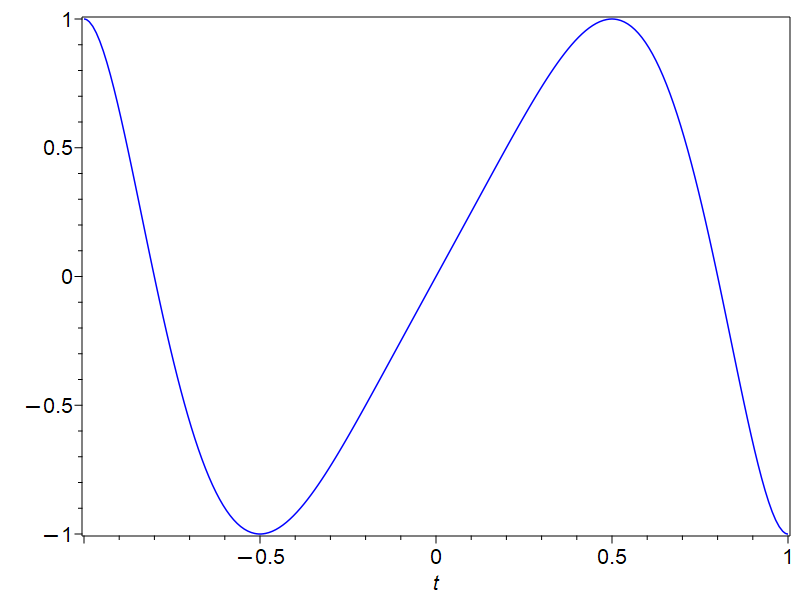

In [3]:
nodes := [-1, -1/2, 1/2, 1]:
rho := [[1, 0], [-1, 0], [1, 0], [-1, 0]]: # Hermite data
pH, barywts := BHIP(rho, nodes, t):
pHplot := plot( pH, t=-1..1, colour=blue );

In [4]:
DpH := diff(pH, t):
limit(DpH, t = -1), limit(DpH, t = -1/2);


                                     0, 0

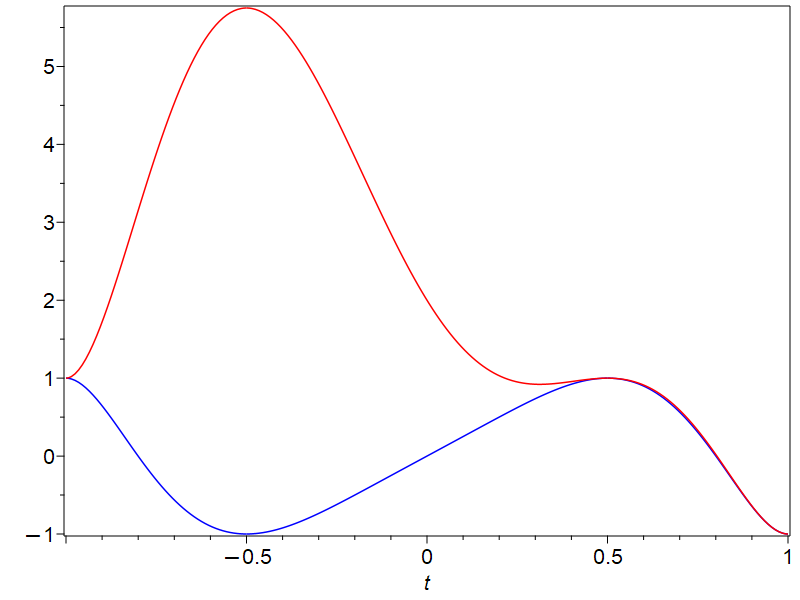

In [5]:
rhomissing := [[1, 0], [undefined, 0], [1, 0], [-1, 0]]:
pB := BHBIP(rhomissing, nodes, t):
pBplot := plot(pB, t = -1 .. 1, colour = red):
plots[display](pHplot, pBplot);

In [6]:
convert(1/((z + 1)^2*(z + 1/2)^2*(z - 1/2)^2*(z - 1)^2), parfrac, true);

64/27/(2*z-1)+76/27/(z+1)-76/27/(z-1)+4/9/(z+1)^2+64/9/(2*z+1)^2-64/27/(2*z+1)+4/9/(z-1)^2+64/9/(2*z-1)^2

In [7]:
zer := 4/9*D(p)(1) + 16/9*D(p)(1/2) + 76/27*p(-1) + 32/27*p(1/2) + 16/9*D(p)(-1/2) - 76/27*p(1) - 32/27*p(-1/2) + 4/9*D(p)(-1) = 0;

4/9*D(p)(1)+16/9*D(p)(1/2)+76/27*p(-1)+32/27*p(1/2)+16/9*D(p)(-1/2)-76/27*p(1)-32/27*p(-1/2)+4/9*D(p)(-1) = 0

In [8]:
peq := isolate( zer, p(-1/2) );

p(-1/2) = 3/8*D(p)(1)+3/2*D(p)(1/2)+19/8*p(-1)+p(1/2)+3/2*D(p)(-1/2)-19/8*p(1)+3/8*D(p)(-1)

In [9]:
eval( peq, [p(-1) = 1, D(p)(-1) = 0, D(p)(-1/2) = 0, p(1/2) = 1, D(p)(1/2) = 0, p(1) = -1, D(p)(1) = 0]);

p(-1/2) = 23/4

In [10]:
latex( peq );

p \left(-\frac{1}{2}\right) = \frac{3 D\left(p \right)\left(1\right)}{8}+\frac{3 D\left(p \right)\left(\frac{1}{2}\right)}{2}+\frac{19 p \left(-1\right)}{8}+p \left(\frac{1}{2}\right)+\frac{3 D\left(p \right)\left(-\frac{1}{2}\right)}{2}-\frac{19 p \left(1\right)}{8}+\frac{3 D\left(p \right)\left(-1\right)}{8}

$p \left(-\frac{1}{2}\right) = \frac{3 D\left(p \right)\left(1\right)}{8}+\frac{3 D\left(p \right)\left(\frac{1}{2}\right)}{2}+\frac{19 p \left(-1\right)}{8}+p \left(\frac{1}{2}\right)+\frac{3 D\left(p \right)\left(-\frac{1}{2}\right)}{2}-\frac{19 p \left(1\right)}{8}+\frac{3 D\left(p \right)\left(-1\right)}{8}$

## A more complicated example ##

Let's see what happens if there are _two_ missing function values.

In [11]:
rho := [[1,0], [undefined,0], [undefined,0], [-1,0]];
rhoB, nds, tv := BHBIP( rho, nodes, nodes[1] );

           rho := [[1, 0], [undefined, 0], [undefined, 0], [-1, 0]]

[[1, 0], [19/8, 0], [-19/8, 0], [-1, 0]], [-1, -1/2, 1/2, 1], -1

What that call did was to _fill in_ the missing data: it said that the undefined values should be replaced by $19/8$ and $-19/8$ respectively.  This data can now be interpolated by the old Hermite code.

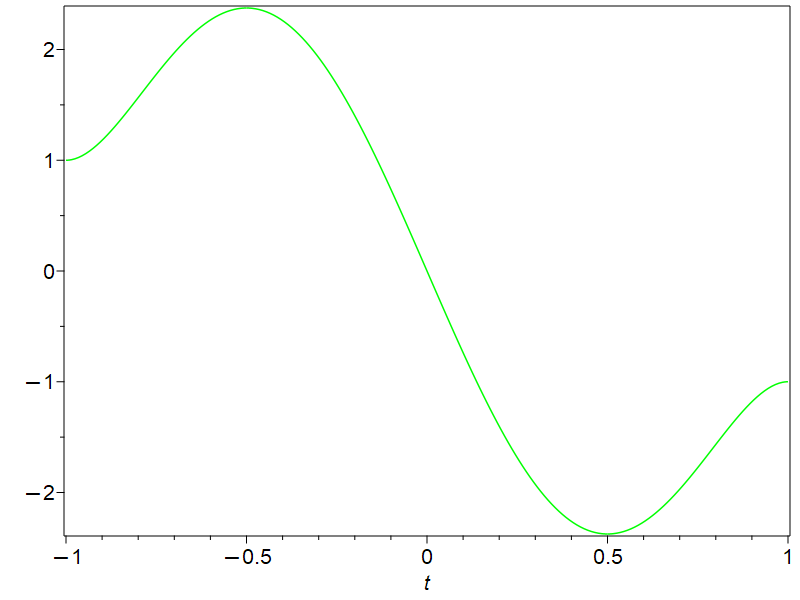

In [12]:
pB := BHBIP( rho, nodes, t ):
plot( pB, t=-1..1, colour=green );

We can use the Hermite interpolational basis companion matrix to find the zeros of that polynomial _without_ changing the polynomial basis.

In [13]:
(A,B) := CMP( rhoB, nodes, t );

In [14]:
Digits := 15:
LinearAlgebra:-Eigenvalues( evalf(A), evalf(B) );

### A Numerical Example ###


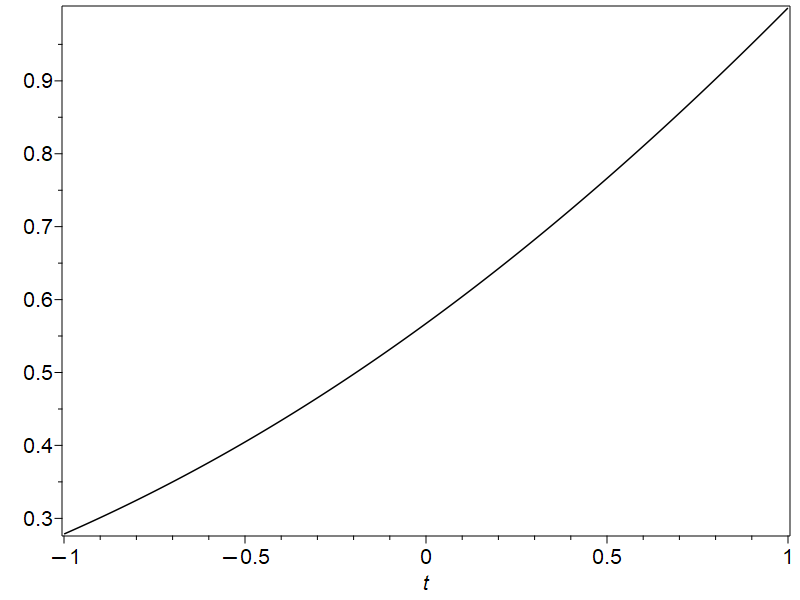

In [15]:
N := 7:
Digits := 15:
tau := [seq(evalf(cos((N - k)*Pi/N)), k = 0 .. N)]:
rho := [seq([Wrightomega(tau[k]), D(Wrightomega)(tau[k])], k = 1 .. N + 1)]:
HermiteInterpolant, gam, DD := BHIP(rho, tau, t, 'Dmat' = true):
plot(HermiteInterpolant, t = -1 .. 1);

In [16]:
holeydata := rho:
holeydata[3] := [undefined, [0.370205964784361, 0.27018271289063][2]]:
holeydata[2] := [undefined, [0.300693832331501, 0.231179563443078][2]]:

In [17]:
filledindata, vals, tau1 := BHBIP(holeydata, tau, tau[1]);

[[.278464542761074, .2178117057198], [.300693832326218, .231179563443078], [.370205964810489, .27018271289063], [.490272659901924, .328981852176091], [.651302306308151, .394417366111648], [.820874655727188, .450813378694297], [.951102406827219, .487469239697086], [1., .5]], [-1., -.900968867902419, -.623489801858734, -.222520933956317, .222520933956317, .623489801858734, .900968867902419, 1.], -1.

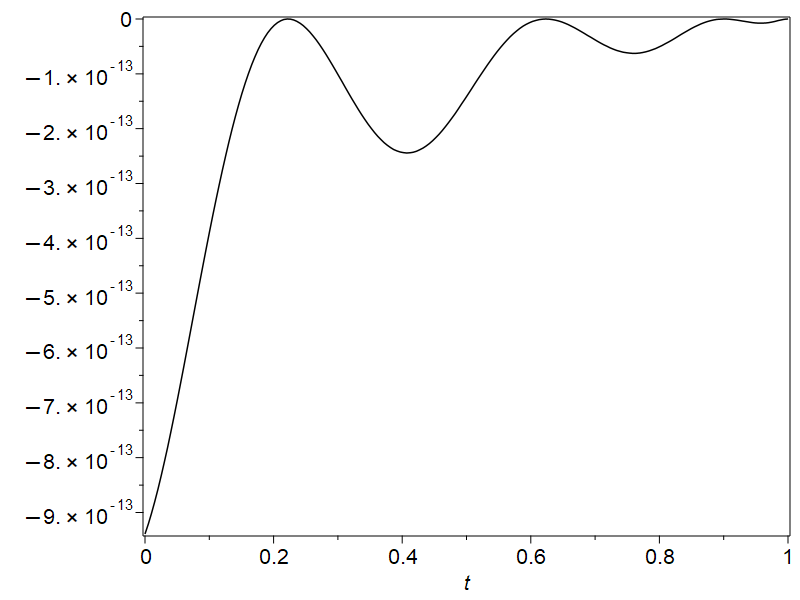

In [18]:
BirkhoffInterpolant, dam := BHIP(filledindata, tau, t):
plot([HermiteInterpolant - BirkhoffInterpolant], t = 0 .. 1);

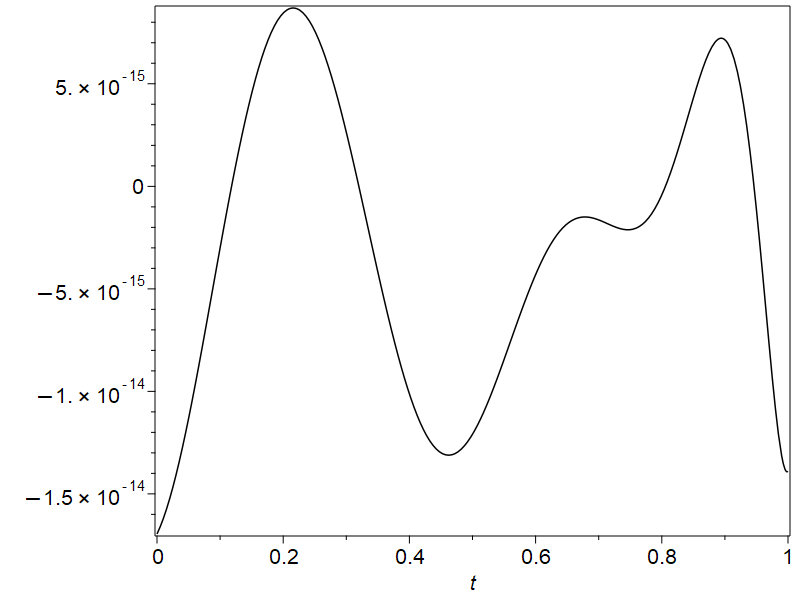

In [19]:
Digits := 30:
BI := BHBIP(holeydata, tau, t):
plot(BI - BirkhoffInterpolant, t = 0 .. 1);

kilobytes used=20622, alloc=18555, time=1.83

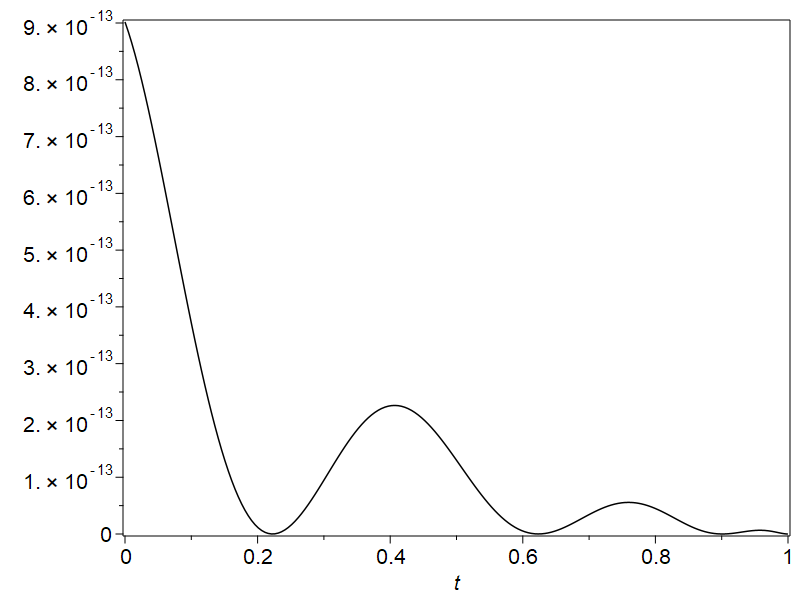

In [20]:
plot(BI - Wrightomega(t), t = 0 .. 1);

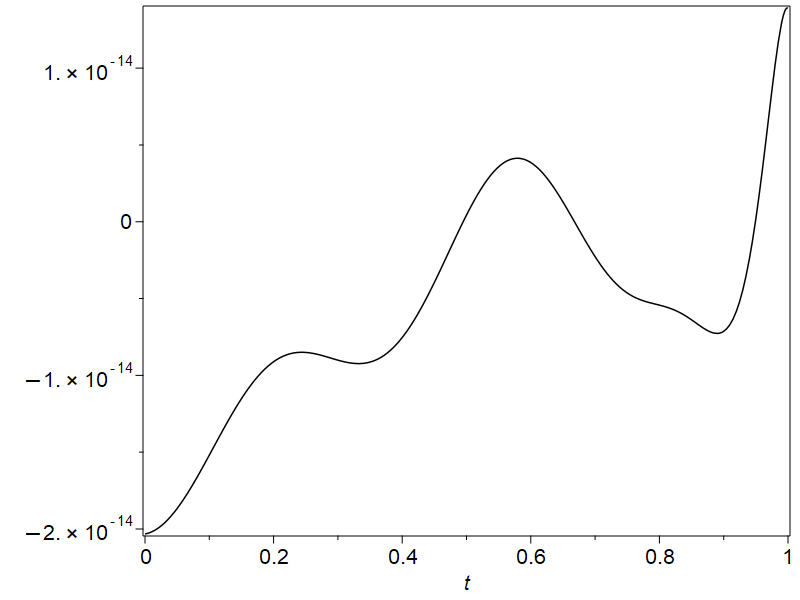

In [21]:
plot(HermiteInterpolant - Wrightomega(t), t = 0 .. 1);

## Dufton's formula ##

In the book by Bennett, Milne, and Bateman (published 1933, the year John was born) which we will review on Friday, we find a reference to a paper by the famous economist von Mises analyzing a curious formula of A. F. Dufton:

\begin{equation}
\int_{t=0}^1 f(t)\,dt \approx \frac14\Biggl( f(0.1) + f(0.4) + f(0.6) + f(0.9)\Biggr) .
\end{equation}

Let's use a Butcher factor to find out what that formula _should_ be.

In [22]:
B := b[0] + b[1]*z + b[2]*z^2 + b[3]*z^3 + b[4]*z^4;

z^4*b[4]+z^3*b[3]+z^2*b[2]+z*b[1]+b[0]

We set the nodes to be 0, 0.1, 0.4, 0.6, 0.9, and 1.0.  Derivative data (the value of f) will be given at the interior nodes only, so this is an open formula; but we need the value of the integral at 0 (which will be 0) and at 1 (which will be the value of the integral)

In [23]:
tau := [1/10,4/10,6/10,9/10]:
w := (z*(z-tau[1])^2*(z-tau[2])^2*(z-tau[3])^2*(z-tau[4])^2*(z-1));

z*(z-1/10)^2*(z-2/5)^2*(z-3/5)^2*(z-9/10)^2*(z-1)

In [24]:
eq := Array(1..4):
for k to 4 do
  eq[k] := residue( B/w, z=tau[k] );
end do:

In [25]:
sol := solve( {seq(eq[k],k=1..4)} );

{b[0] = b[0], b[1] = -20425/5832*b[0], b[2] = 48775/17496*b[0], b[3] = 3125/2187*b[0], b[4] = -3125/4374*b[0]}

In [26]:
nice := eval( eval(B/w, sol), b[0]=17496 );

(-12500*z^4+25000*z^3+48775*z^2-61275*z+17496)/z/(z-1/10)^2/(z-2/5)^2/(z-3/5)^2/(z-9/10)^2/(z-1)

That formula is degree 4 above degree 10, so the contour integral will be zero for all polynomials F of grade 4 (we need the grade of the numerator to be two less than the degree of the denominator).

\begin{equation}
0 = \frac{1}{2\pi i} \oint_C \frac{B(z) F(z)}{z (z-0.1)^2(z-0.4)^2(z-0.6)^2(z-0.9)^2(z-1)}\,dz
\end{equation}

In [27]:
convert( nice, parfrac, z, true );

-37500000/z+37500000/(z-1)-718750000/3/(5*z-2)^2-2750000000/3/(10*z-1)^2-718750000/3/(5*z-3)^2-2750000000/3/(10*z-9)^2

We translate that partial fraction expansion to a polynomial by the Cauchy Integral Formula (I just cut-and-pasted this form and edited it rather than fight Maple's insistence on writing $1/(z-2/5)^2$ as $5^2/(5z-2)^2$, which you can do and would do if the formula was more complicated ):

In [28]:
quad := -718750000/3/(5)^2*D(F)(2/5)-2750000000/3/(10)^2*D(F)(1/10)-37500000*F(0)+37500000*F(1) 
-718750000/3/(5)^2*D(F)(3/5)-2750000000/3/(10)^2*D(F)(9/10) = 0;

-28750000/3*D(F)(2/5)-27500000/3*D(F)(1/10)-37500000*F(0)+37500000*F(1)-28750000/3*D(F)(3/5)-27500000/3*D(F)(9/10) = 0

In [29]:
isolate(quad, F(1));

F(1) = 23/90*D(F)(2/5)+11/45*D(F)(1/10)+F(0)+23/90*D(F)(3/5)+11/45*D(F)(9/10)

In [30]:
22./90, 23./90;

.244444444444444444444444444444, .255555555555555555555555555556

So the _true_ quadrature formula has weights 22/90 and 23/90, not 1/4, but those are not that far from 1/4.  So Dufton's formula is only second-order accurate, but its error coefficients are small.

In [31]:
Dufton := f -> (f(1/10)+f(4/10)+f(6/10)+f(9/10))/4;

f -> 1/4*f(1/10)+1/4*f(2/5)+1/4*f(3/5)+1/4*f(9/10)

In [32]:
Dufton(1)-1;

0

In [33]:
Dufton( t->t )- 1/2;

0

In [34]:
Dufton( t->t^2) -1/3;

1/600

In [35]:
Dufton( t->t^3 ) - 1/4;

1/400

In [36]:
Fourth := f -> 11*(f(1/10)+f(9/10))/45 + 23*(f(4/10)+f(6/10))/90;

f -> 11/45*f(1/10)+11/45*f(9/10)+23/90*f(2/5)+23/90*f(3/5)

In [37]:
Fourth(1)-1, Fourth(t->t)-1/2, Fourth(t->t^2)-1/3, Fourth(t->t^3)-1/4;

0, 0, 0, 0

In [38]:
Fourth(t->t^4)-1/5;

1/15000